In [4]:
# You only need to run this section once.

%load_ext autoreload
%autoreload 2

import os

print("original dir: ", os.getcwd())

if os.getcwd().endswith("NewMethod"):
    new_path = "../"
    os.chdir(new_path)
    print("changed dir: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
original dir:  f:\MyCourse(5 delayed 1)\erasure code\non-linear erasure code\src\NewMethod
changed dir:  f:\MyCourse(5 delayed 1)\erasure code\non-linear erasure code\src


In [2]:
import datetime

TASK_CONFIG = {
    "TASK": "CIFAR10",
    "DATE": datetime.datetime.now().strftime("%Y_%m_%d"),
    "MODEL": "ResNet18",
}

读取数据集

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 设置数据转换
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# 设置数据集（训练集与测试集合）

"""
CIFAR-10:
image: (3, 32, 32), label: (0-9)
train_dataset: [(image, label), (image, label), ...], len(train_dataset): 50000
test_dataset: [(image, label), (image, label), ...], len(test_dataset): 10000
"""

# CIFAR-10
dataset_name = TASK_CONFIG["TASK"]
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


设置部分超参

In [6]:
import datetime

K = 4
R = 0
N = K + R
original_data_shape = tuple(train_dataset[0][0].shape)
num_classes = 10
print(f"K: {K}")
print(f"R: {R}")
print(f"N: {N}")
print(f"data_shape: {original_data_shape}")
print(f"num_classes: {num_classes}")

base_model_path = f"./base_model/{TASK_CONFIG['MODEL']}/{TASK_CONFIG['TASK']}/2024_02_06/model.pth"
encoder_path = f"./encoder/MLP/{TASK_CONFIG['TASK']}/{TASK_CONFIG['DATE']}/encoder-task_{TASK_CONFIG['TASK']}-basemodel_{TASK_CONFIG['MODEL']}-in_{K}-out_{R}.pth"
decoder_path = f"./decoder/MLP/{TASK_CONFIG['TASK']}/{TASK_CONFIG['DATE']}/decoder-task_{TASK_CONFIG['TASK']}-basemodel_{TASK_CONFIG['MODEL']}-in_{N}-out_{K}.pth"
save_dir = f"./save/{TASK_CONFIG['TASK']}/{TASK_CONFIG['MODEL']}/{TASK_CONFIG['DATE']}/"
print(f"base_model_path: {base_model_path}")
print(f"encoder_path: {encoder_path}")
print(f"decoder_path: {decoder_path}")
print(f"save_dir: {save_dir}")

epoch_num = 4
print(f"epoch_num: {epoch_num}")

K: 4
R: 0
N: 4
data_shape: (3, 32, 32)
num_classes: 10
base_model_path: ./base_model/ResNet18/CIFAR10/2024_02_06/model.pth
encoder_path: ./encoder/MLP/CIFAR10/2024_02_16/encoder-task_CIFAR10-basemodel_ResNet18-in_4-out_0.pth
decoder_path: ./decoder/MLP/CIFAR10/2024_02_16/decoder-task_CIFAR10-basemodel_ResNet18-in_4-out_4.pth
save_dir: ./save/CIFAR10/ResNet18/2024_02_16/
epoch_num: 4


定义 base model

In [7]:
import torch

from base_model.VGG16 import VGG16
from base_model.ResNet18 import ResNet18

# 引入 base model, 该model将在后续全部过程中使用
# ResNet
assert TASK_CONFIG["MODEL"] == "ResNet18"
model = ResNet18(input_dim=original_data_shape, num_classes=num_classes)

# 读取模型
model.load_state_dict(torch.load(base_model_path))

conv_segment = model.get_conv_segment()
fc_segment = model.get_fc_segment()

x = torch.randn(1, *original_data_shape)

print(model(x).data)

y = conv_segment(x)
y = y.view(y.size(0), -1)
y = fc_segment(y)
print(y.data)

tensor([[-1.3150, -1.9806, -2.3473, -0.3044,  4.4703,  1.2104,  1.8691,  0.3243,
         -5.7492,  2.7389]])
tensor([[-1.3150, -1.9806, -2.3473, -0.3044,  4.4703,  1.2104,  1.8691,  0.3243,
         -5.7492,  2.7389]])


设置另一部分超参

In [8]:
import torch

conv_output_data_shape = model.calculate_conv_output(input_dim=original_data_shape)
print(f"conv_output_data_shape: {conv_output_data_shape}")

assert conv_output_data_shape[2] % K == 0
split_conv_output_data_shape = tuple(
    [conv_output_data_shape[0], conv_output_data_shape[1], conv_output_data_shape[2] // K]
)
print(f"split_conv_output_data_shape: {split_conv_output_data_shape}")

split_data_shape = (3, 32, 8)
print(f"split_data_shape: {split_data_shape}")
# print(conv_segment)
print(f"split_conv_output_data_shape from split_data_shape: {tuple(conv_segment(torch.randn(1, *split_data_shape)).shape)}")


conv_output_data_shape: (512, 4, 4)
split_conv_output_data_shape: (512, 4, 1)
split_data_shape: (3, 32, 8)
split_conv_output_data_shape from split_data_shape: (1, 512, 4, 1)


定义 Encoder, Decoder

In [21]:
from encoder.mlp_encoder import MLPEncoder
from encoder.conv_encoder import CatChannelConvEncoder, CatBatchSizeConvEncoder
from decoder.mlp_decoder import MLPDecoder
from decoder.conv_decoder import CatChannelConvDecoder, CatBatchSizeConvDecoder

# encoder = MLPEncoder(num_in=K, num_out=R, in_dim=split_data_shape)
# decoder = MLPDecoder(num_in=N, num_out=K, in_dim=split_conv_output_data_shape)

encoder = CatChannelConvEncoder(num_in=K, num_out=R, in_dim=split_data_shape)
decoder = CatChannelConvDecoder(num_in=N, num_out=K, in_dim=split_conv_output_data_shape)

# encoder = CatBatchSizeConvEncoder(num_in=K, num_out=R, in_dim=split_data_shape)
# decoder = CatBatchSizeConvDecoder(num_in=N, num_out=K, in_dim=split_conv_output_data_shape)

训练 Encoder, Decoder

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import datetime
import os

from dataset.image_dataset import ImageDataset
from util.split_data import split_vector

print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")
print("image size: ", train_dataset[0][0].size())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# 定义损失函数
criterion = nn.MSELoss()
criterion2 = nn.CrossEntropyLoss()
optimizer_encoder = optim.SGD(encoder.parameters(), lr=0.001, momentum=0.9)
optimizer_decoder = optim.SGD(decoder.parameters(), lr=0.001, momentum=0.9)

conv_segment.to(device)
fc_segment.to(device)
encoder.to(device)
decoder.to(device)

conv_segment.eval()
fc_segment.eval()
encoder.train()
decoder.train()

model.eval()
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.track_running_stats = False

loss_list = [[] for _ in range(epoch_num)]

for epoch in range(epoch_num):
    train_loader_tqdm = tqdm(
        train_loader,
        desc=f"Epoch {epoch+1}/{epoch_num}",
        bar_format="{l_bar}{bar:20}{r_bar}",
    )
    correct = 0
    correct_truth = 0
    total = 0
    for images, labels in train_loader_tqdm:
        # split image tensor(64, 3, 32, 32) -> [tensor(64, 3, 32, 8) * K]
        images_list = []
        for start, end in split_vector(
            L=original_data_shape[2], k=K, l=split_data_shape[2]
        ):
            images_list.append(images[:, :, :, start:end].clone())

        images_list = [images.to(device) for images in images_list]
        labels = labels.to(device)

        images = images.to(device)
        ground_truth = conv_segment(images)
        ground_truth = ground_truth.view(ground_truth.size(0), -1)

        # forward
        images_list += encoder(images_list)
        output_list = []
        for i in range(N):
            output = conv_segment(images_list[i])
            output_list.append(output)
        # losed_output_list = lose_something(output_list, self.lose_device_index)
        decoded_output_list = decoder(output_list)
        output = torch.cat(decoded_output_list, dim=3)
        output = output.view(output.size(0), -1)

        loss = criterion(output, ground_truth)
        # loss = criterion2(fc_segment(output), fc_segment(ground_truth))
        loss_list[epoch].append(loss.item())

        # backward
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()

        # calculate accuracy
        _, predicted = torch.max(fc_segment(output).data, 1)
        _, predicted_truth = torch.max(fc_segment(ground_truth.data), 1)
        # print(predicted)
        # print(predicted_truth)
        # print(labels)
        correct += (predicted == labels).sum().item()
        correct_truth += (predicted_truth == labels).sum().item()
        total += labels.size(0)

        train_loader_tqdm.set_postfix(loss=loss.item())

    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")
    print(f"Train Accuracy: {100 * correct / total}%")
    print(f"Original Accuracy: {100 * correct_truth / total}%")
    # 27%
    # 10%

Train dataset: 50000
Test dataset: 10000
image size:  torch.Size([3, 32, 32])
Device: cuda


Epoch 1/4: 100%|████████████████████| 782/782 [04:06<00:00,  3.17it/s, loss=0.988]


Epoch: 1, Loss: 0.9884555339813232
Train Accuracy: 10.0%
Original Accuracy: 65.448%


Epoch 2/4:   5%|█                   | 43/782 [00:13<03:56,  3.13it/s, loss=0.953]


KeyboardInterrupt: 

保存模型

In [15]:
import os


os.makedirs(os.path.dirname(encoder_path), exist_ok=True)
os.makedirs(os.path.dirname(decoder_path), exist_ok=True)

torch.save(encoder.state_dict(), encoder_path)
torch.save(decoder.state_dict(), decoder_path)

In [19]:
print(*loss_list)

path = save_dir + 'loss2.txt'
os.makedirs(os.path.dirname(path), exist_ok=True)
with open (path, 'w') as f:
    for loss in loss_list:
        f.write(' '.join(map(str, loss)) + '\n')

[0.2601187229156494, 0.26048094034194946, 0.26030564308166504, 0.2600433826446533, 0.26013463735580444, 0.25998711585998535, 0.2597982883453369, 0.2600659132003784, 0.2594950795173645, 0.259482741355896, 0.25943613052368164, 0.25985145568847656, 0.25924673676490784, 0.25947314500808716, 0.25912952423095703, 0.2587016224861145, 0.25878411531448364, 0.2591218054294586, 0.25886058807373047, 0.2581619620323181, 0.25840649008750916, 0.258434534072876, 0.25770869851112366, 0.2577586770057678, 0.25765109062194824, 0.2580875754356384, 0.25721490383148193, 0.25733238458633423, 0.2572248578071594, 0.25699079036712646, 0.2568736970424652, 0.2571099102497101, 0.2567161023616791, 0.2565695643424988, 0.256642609834671, 0.2560160756111145, 0.2559460997581482, 0.25592660903930664, 0.256087064743042, 0.2556203007698059, 0.25509336590766907, 0.25479450821876526, 0.25526127219200134, 0.2549249827861786, 0.2544858753681183, 0.25484490394592285, 0.2543456554412842, 0.2542656362056732, 0.25426825881004333, 

In [7]:
import os

with open("loss.txt", "r") as f:
    loss_list = [list(map(float, line.split())) for line in f.readlines()]

记录的loss数量: 1838
最后一个loss: 0.5641474723815918


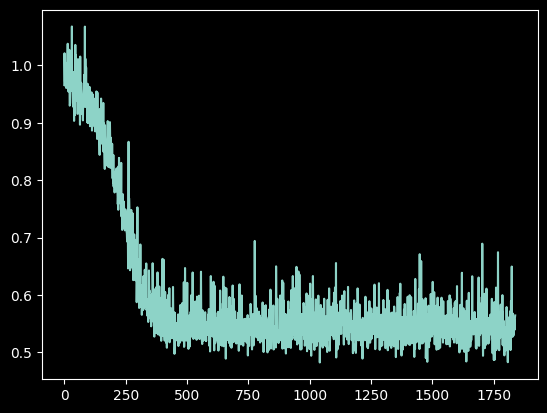

In [12]:
import matplotlib.pyplot as plt

y = [e for l in loss_list for e in l]
print(f"记录的loss数量: {len(y)}")
print(f"最后一个loss: {y[-1]}")

plt.figure()
plt.plot(y)
plt.show()

在测试集上评估 Encoder, Decoder

In [ ]:
# 加载模型
encoder = MLPEncoder(num_in=K, num_out=R, in_dim=split_data_shape)
decoder = MLPDecoder(num_in=N, num_out=K, in_dim=split_conv_output_data_shape)

encoder.load_state_dict(torch.load(encoder_path))
decoder.load_state_dict(torch.load(decoder_path))

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import datetime
import os

from dataset.image_dataset import ImageDataset
from util.split_data import split_vector

print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")
print("image size: ", train_dataset[0][0].size())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

conv_segment.to(device)
fc_segment.to(device)
model.to(device)
encoder.to(device)
decoder.to(device)

conv_segment.eval()
fc_segment.eval()
model.eval()
encoder.eval()
decoder.eval()

original_correct = 0
merge_correct = 0
correct = 0
total = 0
with torch.no_grad():
    test_loader_tqdm = tqdm(
        test_loader,
        desc=f"Test",
        bar_format="{l_bar}{bar:20}{r_bar}",
    )
    for images, labels in test_loader_tqdm:

        # split image tensor(64, 3, 32, 32) -> [tensor(64, 3, 32, 8) * K]
        images_list = []
        for start, end in split_vector(L=original_data_shape[2], k=K, l=split_data_shape[2]):
            images_list.append(images[:,:,:,start:end].clone())

        images_list = [images.to(device) for images in images_list]
        labels = labels.to(device)

        images = images.to(device)
        ground_truth = conv_segment(images)

        _, predicted = torch.max(model(images).data, 1)
        original_correct += (predicted == labels).sum().item()

        output = conv_segment(images)
        output = output.view(output.size(0), -1)
        output = fc_segment(output)
        _, predicted = torch.max(output.data, 1)
        merge_correct += (predicted == labels).sum().item()

        imageDataset_list = [
            ImageDataset(images)
            for images in images_list + encoder(images_list)
        ]
        output_list = []
        for i in range(N):
            imageDataset = imageDataset_list[i]
            output = conv_segment(imageDataset.images)
            output_list.append(output)
        # losed_output_list = lose_something(output_list, self.lose_device_index)
        decoded_output_list = decoder(output_list)
        output = torch.cat(decoded_output_list, dim=3)
        output = output.view(output.size(0), -1)

        _, predicted = torch.max(fc_segment(output).data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"测试集总数: {total}")
print(f"原始模型 -> 预测正确数: {original_correct}, 预测准确率: {100 * original_correct / total}%")
print(f"合并模型(conv+fc) -> 预测正确数: {merge_correct}, 预测准确率: {100 * merge_correct / total}%")
print(f"使用Encoder和Decoder -> 预测正确数: {correct}, 预测准确率: {100 * correct / total}%")

Train dataset: 50000
Test dataset: 10000
image size:  torch.Size([3, 32, 32])
Device: cuda


Test: 100%|████████████████████| 157/157 [00:32<00:00,  4.86it/s]

测试集总数: 10000
原始模型 -> 预测正确数: 5229, 预测准确率: 52.29%
合并模型(conv+fc) -> 预测正确数: 5229, 预测准确率: 52.29%
使用Encoder和Decoder -> 预测正确数: 1000, 预测准确率: 10.0%


In [8]:
x = torch.randn(1, *original_data_shape).to(device)

print("x 经过完整的 model 得: ")
print(model(x).data)

y = conv_segment(x)
y = y.view(y.size(0), -1)
output_truth = y.data
y = fc_segment(y)
print("x 经过 conv 和 fc 得: ")
print(y.data)

print("-" * 20)

model.eval()
for m in model.modules():
    if isinstance(m, nn.BatchNorm2d):
        m.track_running_stats = False

images_list = []
for start, end in split_vector(L=original_data_shape[2], k=2, l=16):
    print(start, end)
    images_list.append(x[:, :, :, start:end].clone())

images_list = [images.to(device) for images in images_list]

output_list = []
for i in range(len(images_list)):
    output = conv_segment(images_list[i])
    output_list.append(output)
    print(output.shape)
output = torch.cat(output_list, dim=3)  # changed
output = output.view(output.size(0), -1).data
print(output.shape, output_truth.shape)
print(output)
print(output_truth)

print(model)
print("-" * 20)
import torch.nn as nn
layers = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
).to(device)
x1 = x
x2 = x[:, :, :, 0:16]
for layer in layers:
    record_layer = layer
    record_x1 = x1.clone()
    record_x2 = x2.clone()
    x1 = layer(x1)
    x2 = layer(x2)
    print("模型")
    print(layer)
    print("输出大小")
    print(x1.shape, x2.shape)
    print("0,0,0,0 值:")
    print(x1[0, 0, 0, 0].data, x2[0, 0, 0, 0].data)
    print("0,0,0,1 值:")
    print(x1[0, 0, 0, 1].data, x2[0, 0, 0, 1].data)
    print("是否相等:")
    # print(x1[:, :, :, 0 : x2.shape[3]].data)
    # print(x2.data)
    is_equal = torch.all(torch.eq(x1[:, :, :, 0 : x2.shape[3]].data, x2.data))
    print(is_equal)
    print(x1[0, 0, 0, 0 : x2.shape[3]].data == x2[0, 0, 0, :].data)
    print("-" * 20)
    print("\n\n\n")


# `print('-'*20)

# import torch.nn as nn
# layer = nn.BatchNorm2d(3)
# # layer = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
# # layer = nn.ReLU(inplace=True)
# layer.to(device)
# layer.eval()
# layer.track_running_stats = False
# output_truth = layer(x)
# output_truth = output_truth.view(output_truth.size(0), -1).data

# output_list = []
# for i in range(N):
#     output = layer(images_list[i])
#     output_list.append(output)
# output = torch.cat(output_list, dim=3)  # changed
# output = output.view(output.size(0), -1).data
# print(output.shape, output_truth.shape)
# print(output)
# print(output_truth)`

NameError: name 'device' is not defined

训练 base model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm
import datetime
import os


print(f"Train dataset: {len(train_dataset)}")
print(f"Test dataset: {len(test_dataset)}")
print("image size: ", train_dataset[0][0].size())

# 部署到设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model.to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0)

t0 = datetime.datetime.now()
# 训练循环
model.train()  # 设置模型为训练模式
num_epochs = 10  # 迭代次数
for epoch in range(num_epochs):
    # 使用 tqdm 包装训练数据加载器
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for data, target in train_loader_tqdm:
        # 将数据移动到设备上
        data, target = data.to(device), target.to(device)

        # target 变为 one-hot 编码
        target = (
            torch.zeros(target.size(0), 10)
            .to(device)
            .scatter_(1, target.view(-1, 1), 1)
        )

        # 正向传播
        output = model(data)
        loss = criterion(output, target)

        # 反向传播和优化
        optimizer.zero_grad()  # 清除之前的梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新权重

        # 更新进度条的描述
        train_loader_tqdm.set_postfix(loss=loss.item())
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
t1 = datetime.datetime.now()

# 测试循环
model.eval()  # 设置模型为评估模式

correct = 0
total = 0
with torch.no_grad():  # 在评估过程中不计算梯度
    for data, target in train_loader:
        # 将数据移动到设备上
        data, target = data.to(device), target.to(device)

        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"训练集-> 总量: {total}, 正确数量: {correct}, 准确率: {100 * correct / total}%")
t2 = datetime.datetime.now()

correct = 0
total = 0
with torch.no_grad():  # 在评估过程中不计算梯度
    for data, target in test_loader:
        # 将数据移动到设备上
        data, target = data.to(device), target.to(device)

        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"测试集-> 总量: {total}, 正确数量: {correct}, 准确率: {100 * correct / total}%")
t3 = datetime.datetime.now()

print(f"训练时间: {t1 - t0}")
print(f"训练集评估时间: {t2 - t1}")
print(f"测试集评估时间: {t3 - t2}")

# 保存模型
now = datetime.datetime.now()
date = now.strftime("%Y_%m_%d")
filepath = f"base_model/{TASK_CONFIG['MODEL']}/{TASK_CONFIG['TASK']}/{TASK_CONFIG['DATE']}/model.pth"
dirpath = os.path.dirname(filepath)
if not os.path.exists(dirpath):
    os.makedirs(dirpath)
torch.save(model.state_dict(), filepath)

# 读取模型
# model = LeNet5(input_dim=(1, 28, 28), num_classes=10)
# model.load_state_dict(torch.load(filepath))

# gpu: 3min58s
# cpu: 5min17s

Train dataset: 50000
Test dataset: 10000
image size:  torch.Size([3, 32, 32])
Device: cuda


Epoch 1/10: 100%|██████████| 782/782 [01:28<00:00,  8.86it/s, loss=1.79] 


Epoch 1/10, Loss: 1.787920594215393


Epoch 2/10: 100%|██████████| 782/782 [01:27<00:00,  8.92it/s, loss=1.36] 


Epoch 2/10, Loss: 1.3618195056915283


Epoch 3/10: 100%|██████████| 782/782 [01:25<00:00,  9.16it/s, loss=0.804]


Epoch 3/10, Loss: 0.8042820692062378


Epoch 4/10: 100%|██████████| 782/782 [01:25<00:00,  9.10it/s, loss=0.738]


Epoch 4/10, Loss: 0.7381492853164673


Epoch 5/10: 100%|██████████| 782/782 [01:24<00:00,  9.26it/s, loss=0.719]


Epoch 5/10, Loss: 0.7186200022697449


Epoch 6/10: 100%|██████████| 782/782 [01:26<00:00,  9.06it/s, loss=0.364]


Epoch 6/10, Loss: 0.3641059696674347


Epoch 7/10: 100%|██████████| 782/782 [01:25<00:00,  9.13it/s, loss=0.578] 


Epoch 7/10, Loss: 0.5779234766960144


Epoch 8/10: 100%|██████████| 782/782 [01:25<00:00,  9.14it/s, loss=0.0786]


Epoch 8/10, Loss: 0.07857557386159897


Epoch 9/10: 100%|██████████| 782/782 [01:26<00:00,  9.03it/s, loss=0.206]  


Epoch 9/10, Loss: 0.20561690628528595


Epoch 10/10: 100%|██████████| 782/782 [01:25<00:00,  9.17it/s, loss=0.0971] 


Epoch 10/10, Loss: 0.09707945585250854
Accuracy on the Test set: 66.21%
